**Regression analysis of Air Quality Dataset**

---



# Data



**Main link:** 

https://archive.ics.uci.edu/ml/datasets/Air+Quality#


**Data Set Information:**

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.
This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded.


**Independent Variables:**

* `Date`: (DD/MM/YYYY)
* `Time`: (HH.MM.SS)
* `CO(GT)`: True hourly averaged concentration CO in $mg/m^3$ (reference analyzer)
* `PT08.S1(CO)`: (tin oxide) hourly averaged sensor response (nominally CO targeted)
* `NMHC(GT)`: True hourly averaged overall Non Metanic HydroCarbons concentration in $microg/m^3$ (reference analyzer)
* `PT08.S2(NMHC)`: (titania) hourly averaged sensor response (nominally NMHC targeted)
* `NOx(GT)`: True hourly averaged NOx concentration in ppb (reference analyzer)
* `PT08.S3(NOx)`: (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
* `NO2(GT)`: True hourly averaged NO2 concentration in $microg/m^3$ (reference analyzer)
* `PT08.S4(NO2)`: (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
* `PT08.S5(O3)`: (indium oxide) hourly averaged sensor response (nominally O3 targeted)
* `T`: Temperature in  °C
* `RH`: Relative Humidity (%)
* `AH`: Absolute Humidity

**Target variable:**

* `C6H6(GT)`: True hourly averaged Benzene concentration in $microg/m^3$ (reference analyzer)

**Relevant Papers:**

* S. De Vito, E. Massera, M. Piga, L. Martinotto, G. Di Francia, On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario, Sensors and Actuators B: Chemical, Volume 129, Issue 2, 22 February 2008, Pages 750-757, ISSN 0925-4005, http://dx.doi.org/10.1016/j.snb.2007.09.060

* Saverio De Vito, Marco Piga, Luca Martinotto, Girolamo Di Francia, CO, NO2 and NOx urban pollution monitoring with on-field calibrated electronic nose by automatic bayesian regularization, Sensors and Actuators B: Chemical, Volume 143, Issue 1, 4 December 2009, Pages 182-191, ISSN 0925-4005, http://dx.doi.org/10.1016/j.snb.2009.08.041

* S. De Vito, G. Fattoruso, M. Pardo, F. Tortorella and G. Di Francia, 'Semi-Supervised Learning Techniques in Artificial Olfaction: A Novel Approach to Classification Problems and Drift Counteraction,' in IEEE Sensors Journal, vol. 12, no. 11, pp. 3215-3224, Nov. 2012.
doi: 10.1109/JSEN.2012.2192425


# EDA

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.graphics.mosaicplot import mosaic

import missingno as msno
!pip install robustats
import robustats
from pathlib import Path

#from pandas_profiling import ProfileReport
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
#from yellowbrick.regressor import PredictionError
from sklearn.metrics import mean_squared_error #, r2_score
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

from yellowbrick.regressor import ResidualsPlot
from scipy import stats

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Let's import the dataset, replace -200 with proper np.NaN, and see its overall structure

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Myoth13/datasets/main/AirQualityUCI.csv', delimiter=';')
df.replace(to_replace=['-200',-200], value=np.NaN, inplace=True, regex=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   object 
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   object 
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   object 
 13  RH             8991 non-null   object 
 14  AH             8991 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


We can see:


1.   There are two totally empty columns: `Unnamed: 15` and `Unnamed: 16` which we will drop  
2.    Violation of the data type constrains - `Date` and `Time` columns should be datetime type and all other columns should be of numerical type  
3.    Column `NMHC(GT)` contains a lot of missing data that needs to be investigated  



Let's begin with dropping two empty columns

In [ ]:
df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

### Data type constrains

Let's see what's inside of the dataset

In [ ]:
df.loc[100:110,:]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
100,14/03/2004,22.00.00,"2,1",1324.0,100.0,"9,0",940.0,146.0,924.0,121.0,1587.0,1423.0,"16,3","51,0","0,9341"
101,14/03/2004,23.00.00,"2,2",1349.0,79.0,"8,8",933.0,152.0,933.0,119.0,1617.0,1349.0,"14,7","55,9","0,9314"
102,15/03/2004,00.00.00,"1,8",1239.0,66.0,"7,4",872.0,104.0,985.0,99.0,1547.0,1250.0,"14,8","54,7","0,9164"
103,15/03/2004,01.00.00,"1,8",1239.0,73.0,"6,9",853.0,106.0,1010.0,93.0,1543.0,1174.0,"14,0","57,0","0,9094"
104,15/03/2004,02.00.00,"1,8",1224.0,66.0,"7,0",855.0,108.0,998.0,88.0,1566.0,1149.0,"13,4","61,3","0,9361"
105,15/03/2004,03.00.00,"1,1",1078.0,44.0,"4,4",734.0,NaN,1128.0,NaN,1487.0,1021.0,"12,6","63,5","0,9230"
106,15/03/2004,04.00.00,NaN,1078.0,44.0,"4,0",711.0,66.0,1150.0,71.0,1468.0,1013.0,"12,3","65,4","0,9351"
107,15/03/2004,05.00.00,1,1075.0,39.0,"3,9",703.0,88.0,1156.0,74.0,1464.0,1010.0,"11,9","67,4","0,9375"
108,15/03/2004,06.00.00,"1,4",1157.0,51.0,"6,4",830.0,138.0,1030.0,80.0,1584.0,1083.0,"11,4","70,5","0,9475"
109,15/03/2004,07.00.00,"2,2",1314.0,107.0,"9,7",966.0,228.0,897.0,89.0,1710.0,1235.0,"11,3","70,2","0,9401"


We can see that in order to convert columns to numerical format, we have to replace "," with "." and instead of separate 'Date' and 'Time' columns I will make one datetime feature. 

In [ ]:
cat_cols = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
df = df.replace(',','.', regex=True)
df[cat_cols] = df[cat_cols].astype(float)
df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df.drop('Time', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   CO(GT)         7674 non-null   float64       
 2   PT08.S1(CO)    8991 non-null   float64       
 3   NMHC(GT)       914 non-null    float64       
 4   C6H6(GT)       8991 non-null   float64       
 5   PT08.S2(NMHC)  8991 non-null   float64       
 6   NOx(GT)        7718 non-null   float64       
 7   PT08.S3(NOx)   8991 non-null   float64       
 8   NO2(GT)        7715 non-null   float64       
 9   PT08.S4(NO2)   8991 non-null   float64       
 10  PT08.S5(O3)    8991 non-null   float64       
 11  T              8991 non-null   float64       
 12  RH             8991 non-null   float64       
 13  AH             8991 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 1.0 MB


In [ ]:
df.head()

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


This looks totally fine now

### Uniqness constrains

Let's check for duplicate rows:

In [ ]:
df.duplicated().sum()

113

Let's drop them

In [ ]:
df.drop_duplicates(inplace=True)

### Missing data

Let's see overall amount of missing values

Text(0.5, 1.0, 'Percent of non-null values by variable')

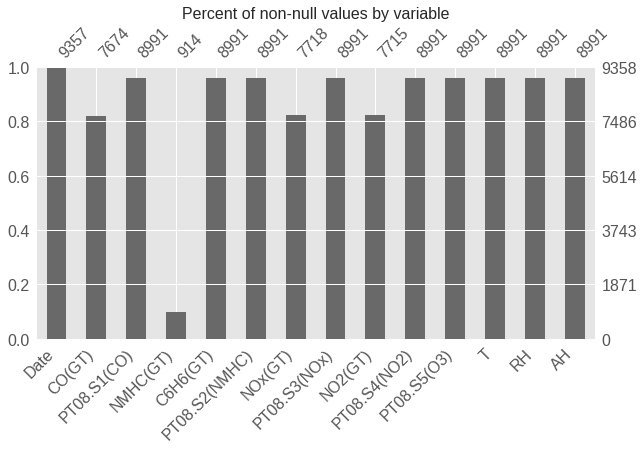

In [ ]:
msno.bar(df, figsize=(10, 5))
plt.title('Percent of non-null values by variable', fontsize=16)
plt.show()

We can see, that `NMHC(GT)` has almost 90% of data missing, I decided to drop this field and do not impute it. 

In [ ]:
df.drop('NMHC(GT)', axis=1, inplace=True)

Now let's see the pattern of missingness:

Text(0.5, 1.0, 'Missing values by variable')

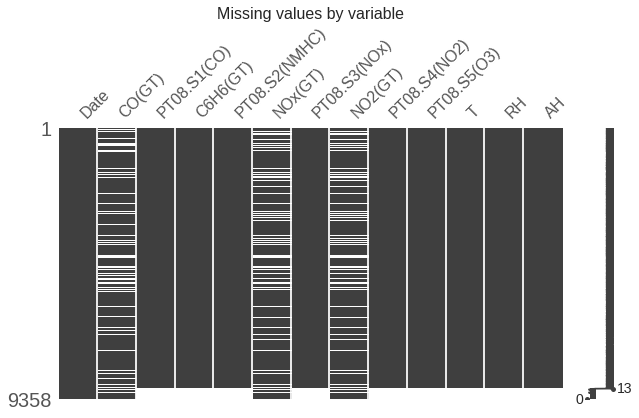

In [ ]:
df.sort_values('C6H6(GT)', inplace=True)
msno.matrix(df, figsize=(10, 5))
plt.title('Missing values by variable', fontsize=16)
plt.show()

We can see a very interesting pattern here:
* We have missing data in our target variable and in the same rows almost all features are missing too. This could be the problem with data recording from sensors. I will drop this rows. 
* Missing data in the other variables looks random, so I will impute it later in the pipeline.

In [ ]:
df.dropna(subset=['C6H6(GT)'], inplace=True)
df.sort_values('C6H6(GT)', inplace=True)

### Useless data and constans

Let's check for useless fields:

In [ ]:
(df.nunique()/len(df)).sort_values(ascending=False)

Date             1.000000
AH               0.743299
PT08.S5(O3)      0.193861
PT08.S4(NO2)     0.178289
PT08.S2(NMHC)    0.138472
PT08.S3(NOx)     0.135802
PT08.S1(CO)      0.115782
NOx(GT)          0.099878
RH               0.083750
T                0.048493
C6H6(GT)         0.045267
NO2(GT)          0.030475
CO(GT)           0.010455
dtype: float64

`Date` is unique column, so it's alright to have 1 there, but `AH` is also close to 1, so it may be useless for the model, but we will see the result later after scaling and a feature importance analysis. 

Let's check for constants - fields with zero variance:

In [ ]:
df.var().sort_values(ascending=True)[0:5]

AH            0.163065
CO(GT)        2.063450
C6H6(GT)     55.499814
T            78.006268
RH          299.874765
dtype: float64

We can see here that we don't have zero variance fields which means we don't have constans

### Data range constrains

Let's see the overall statistics:

In [ ]:
df.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7344.000000,8991.000000,8991.000000,8991.000000,7396.000000,8991.000000,7393.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.129711,1099.833166,10.083105,939.153376,242.189292,835.493605,112.145137,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.436472,217.080037,7.449820,266.831429,206.312007,256.817320,47.629141,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,937.000000,4.400000,734.500000,97.000000,658.000000,77.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1.800000,1063.000000,8.200000,909.000000,178.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,2.800000,1231.000000,14.000000,1116.000000,321.000000,969.500000,140.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,11.900000,2040.000000,63.700000,2214.000000,1479.000000,2683.000000,333.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


It looks quite reasonable for me from the first glance, but we will see later the potential and real outliers thou. 

### Target variable

Let's look at the distribution of the target variable:

In [ ]:
fig = px.histogram(
    data_frame=df,
    x='C6H6(GT)',
    title='Distribution of the target variable',
    nbins=20,
    width = 600,
    height = 500
    )
fig.show()

We can see that out target variable doesn't have normal distribution. Let's see how the log transformation will look like

In [ ]:
df['C6H6(GT)_transformed'] = np.log10(df['C6H6(GT)'])
fig = px.histogram(
    data_frame=df,
    x='C6H6(GT)_transformed',
    title='Distribution of the target variable transformed',
    nbins=20,
    width = 600,
    height = 500
    )
fig.show()

After log transformation distribution looks skewed to the left, but overall shape is much better then before, so I will use transformed version of the target variable

### Independent variables

#### Distribution and dependences

Text(0.5, 0.98, 'Distribution of the numeric variables')

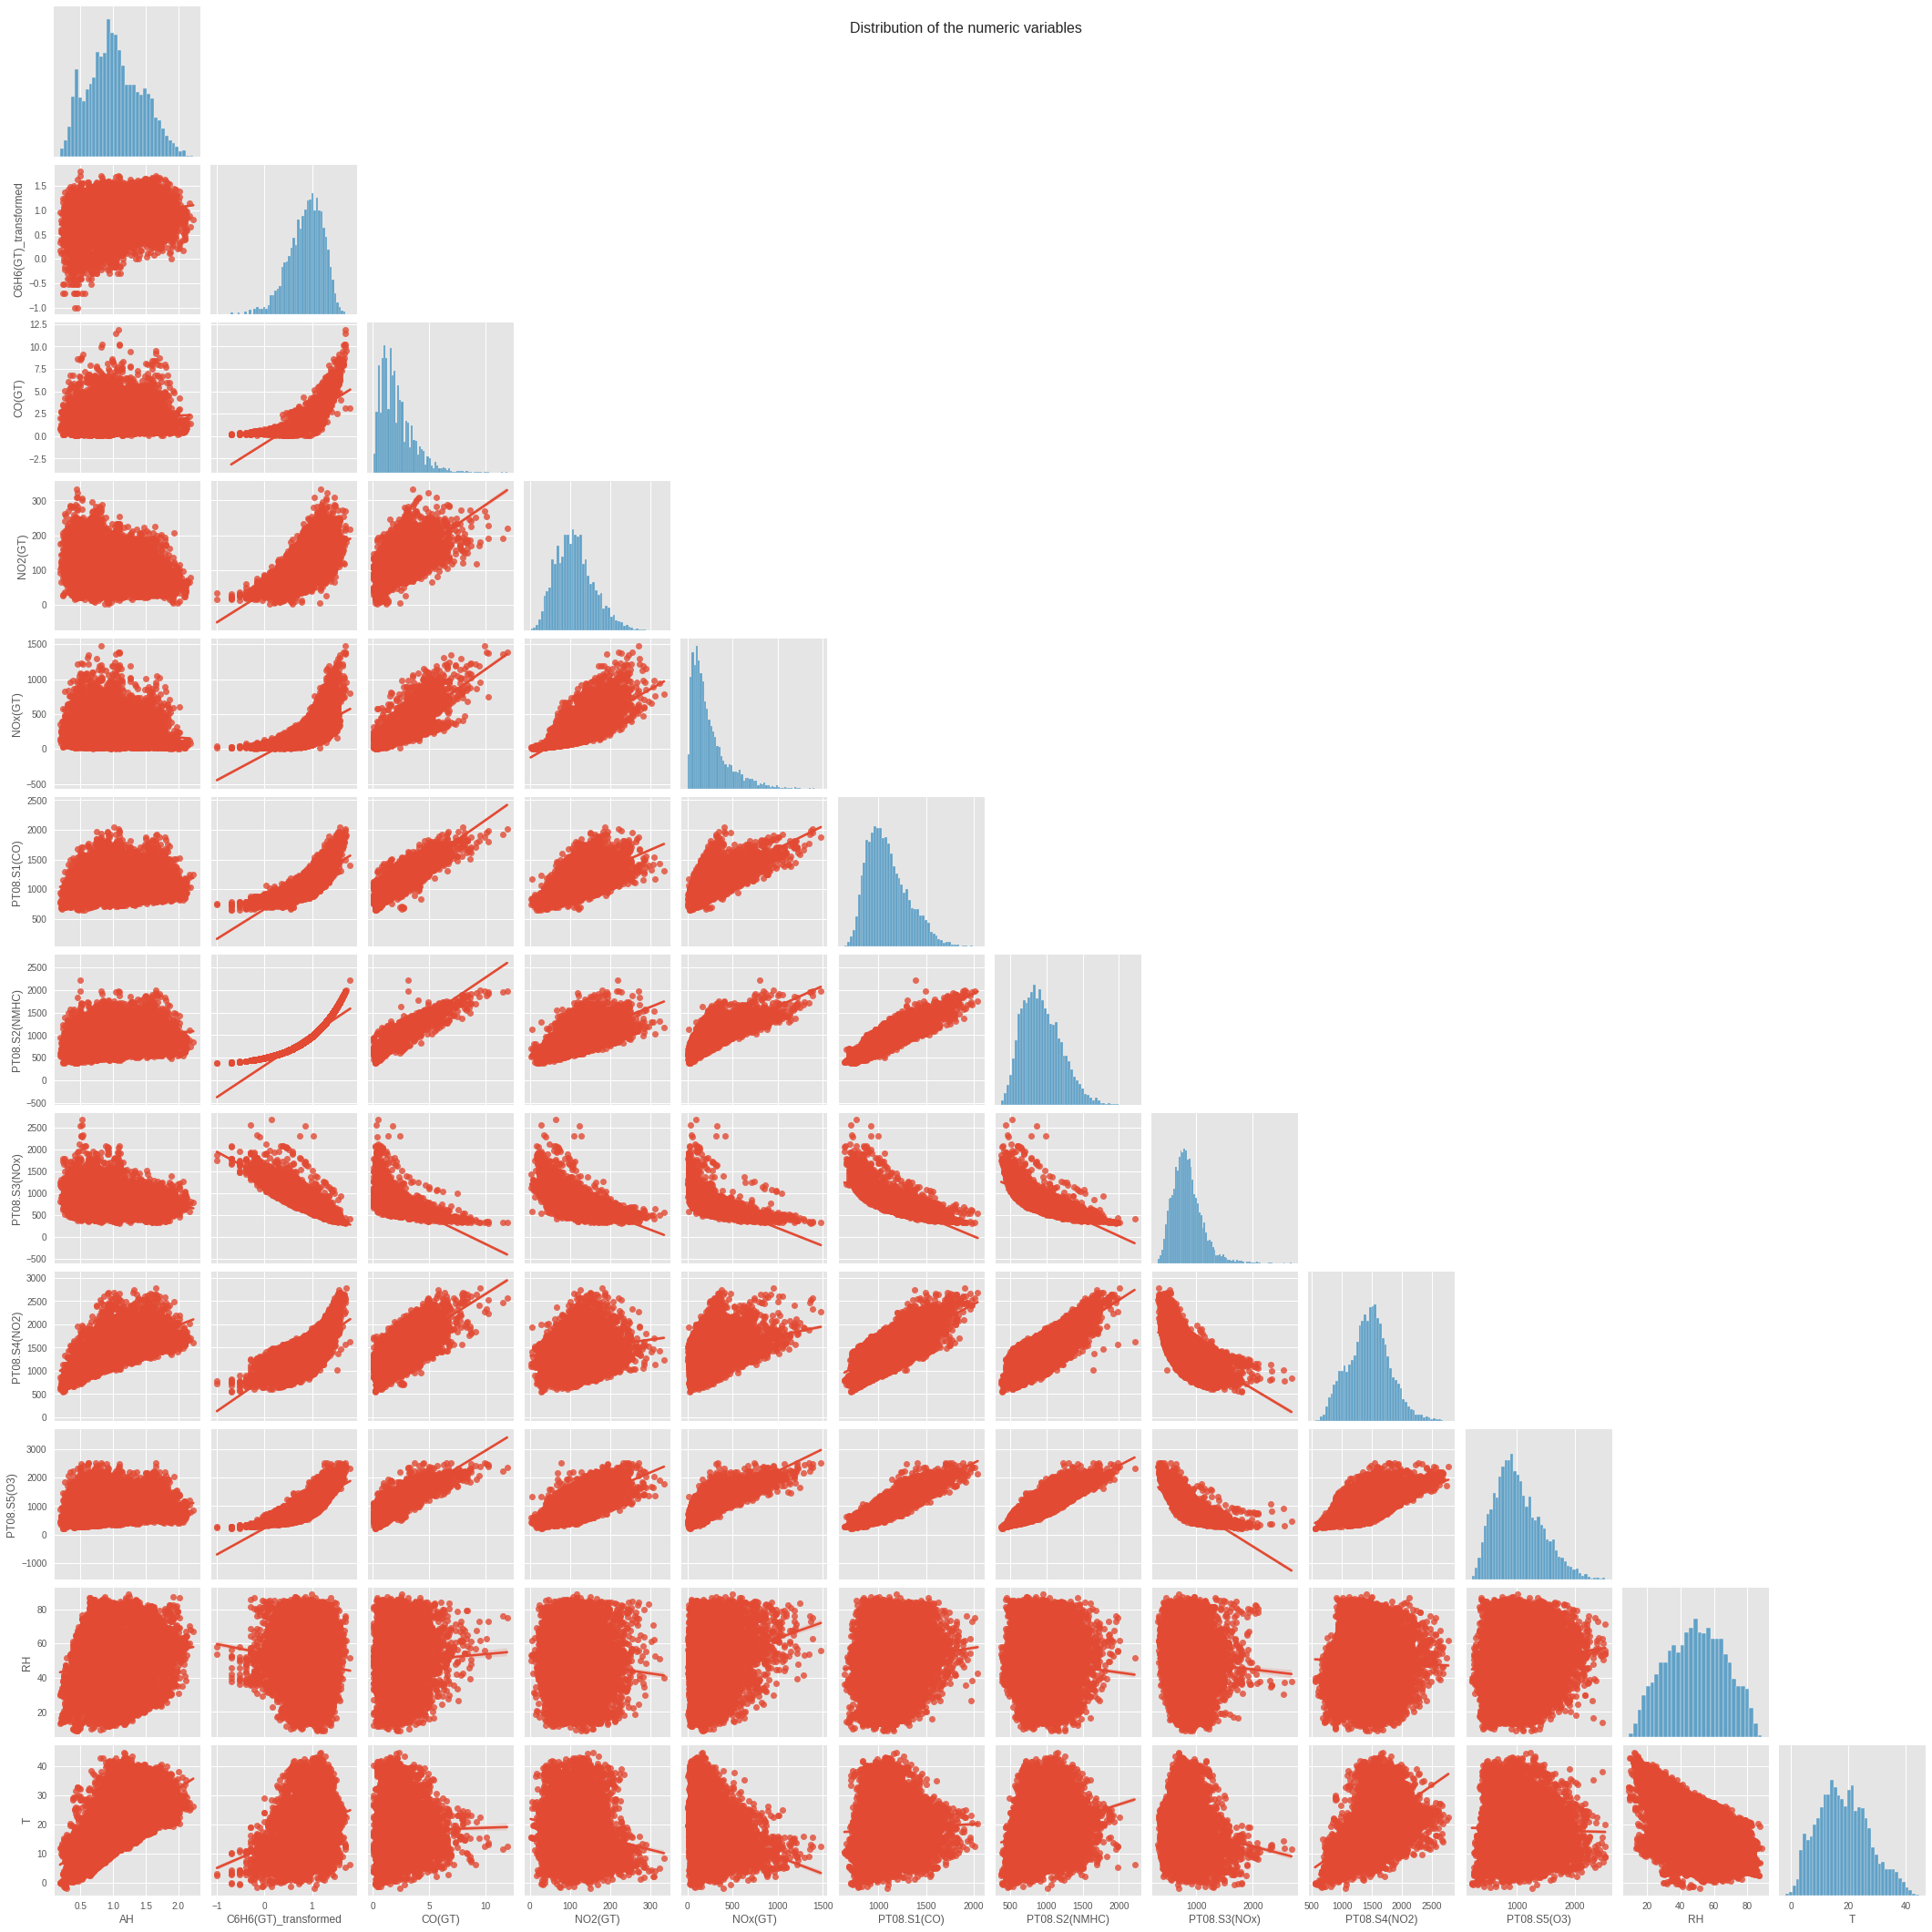

In [ ]:
sns.pairplot(df[df.columns.difference(['C6H6(GT)'])], corner=True, kind="reg")
plt.suptitle('Distribution of the numeric variables', fontsize=16)
plt.show()

We can see here:
* All features except for `AH`, `PH` and `T` are need to be transformed in order for relationship to be linear. Let's see how transformation will work: 

Text(0.5, 0.98, 'Distribution of the numeric variables')

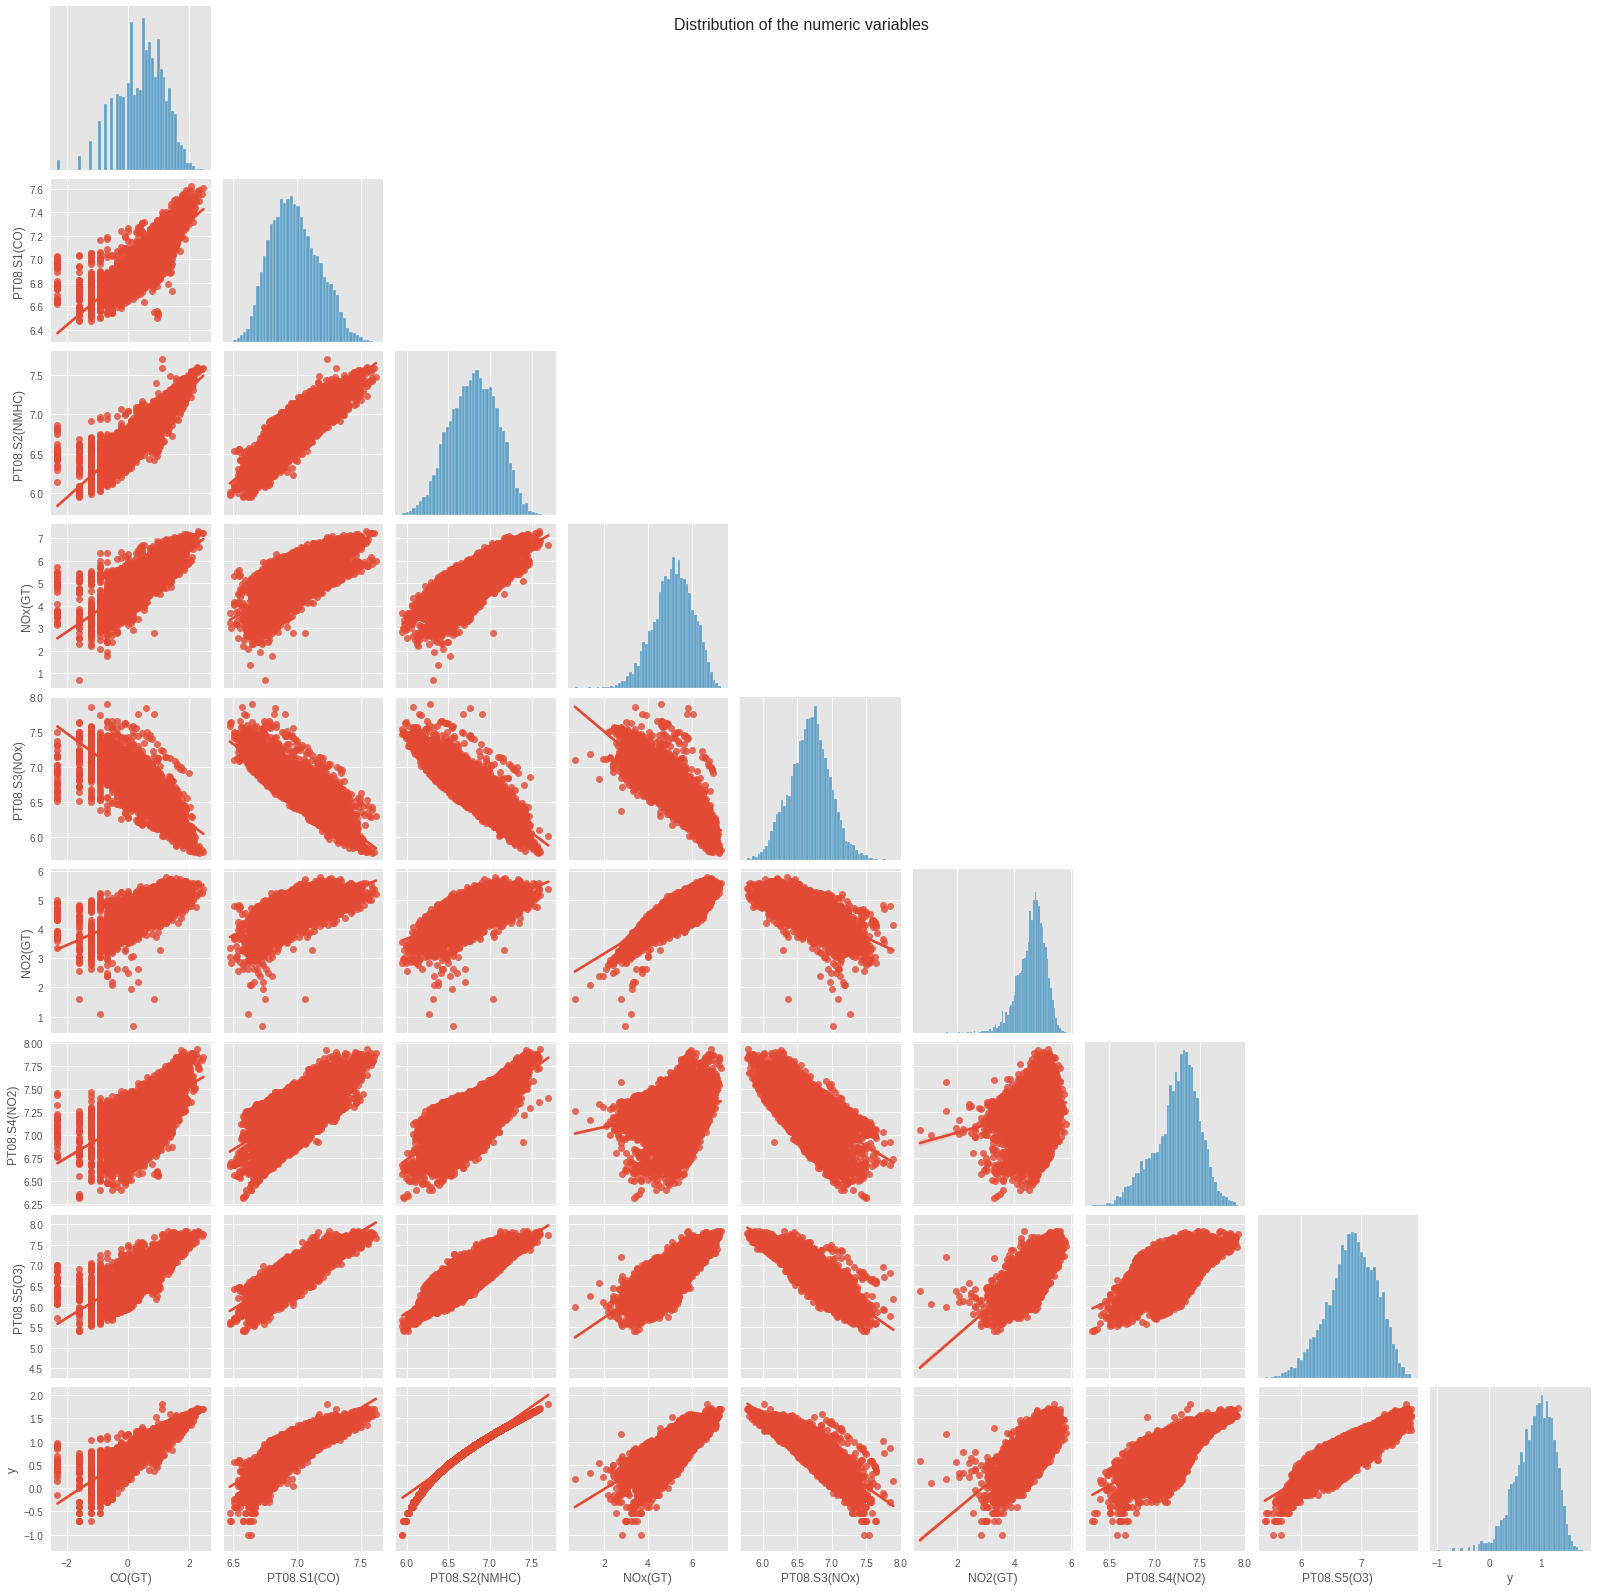

In [ ]:
y = df['C6H6(GT)_transformed']
X = df.drop(['Date','C6H6(GT)_transformed', 'C6H6(GT)', 'AH', 'RH', 'T'], axis=1)
X_labels = X.columns

X = np.log(X)
new_df = pd.DataFrame(X, columns=X_labels)
new_df['y']  = y
sns.pairplot(new_df, corner=True, kind="reg")
plt.suptitle('Distribution of the numeric variables', fontsize=16)
plt.show()

That looks better - all distributions has nice shape but dependences are still not all linear. 

#### Correlations

Let's look at the correlations between variables. I will use original dataset, o I will use spearmans correlation coefficient instead of Pearsons because of the non-linearity

Text(0.5, 1.0, 'Spearmans corr')

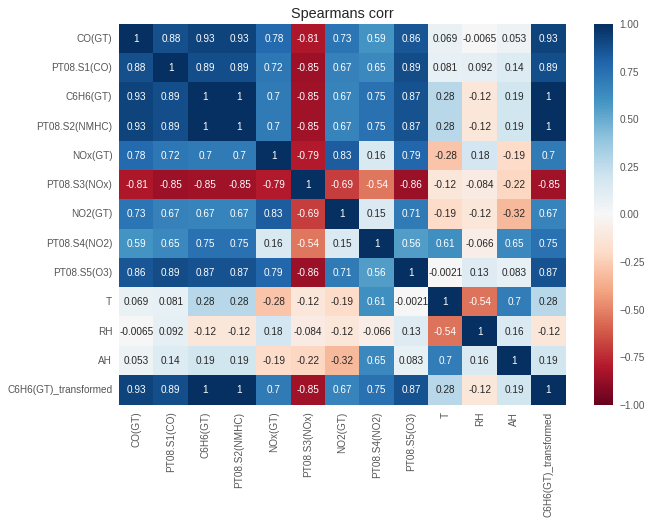

In [ ]:
corr_table = df.corr(method='spearman')
sns.heatmap(corr_table, cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Spearmans corr')
plt.show()

We can see here:

* Target variable has perfect correlation with `PT08.S2(NMHC)`: (titania) hourly averaged sensor response (nominally NMHC targeted). Because Benzene is NMHC, it would be reasonable to exclude this variable from analysis all together, otherwise it is not interesting =). But unfortunately I don't have much time now to read research papers, so I will exclude this column from my regression analysis. 

* A lot of independent variables have strong correlations between each other, which I will try to solve using PCA and elastic net regression. 

# PCA

### Splitting into test and train datasets

Because our dataset has time component, I will use `TimeSeriesSplit` 

Text(0, 0.5, 'Response variable')

Text(0.5, 1.0, 'Training/test set splitting')

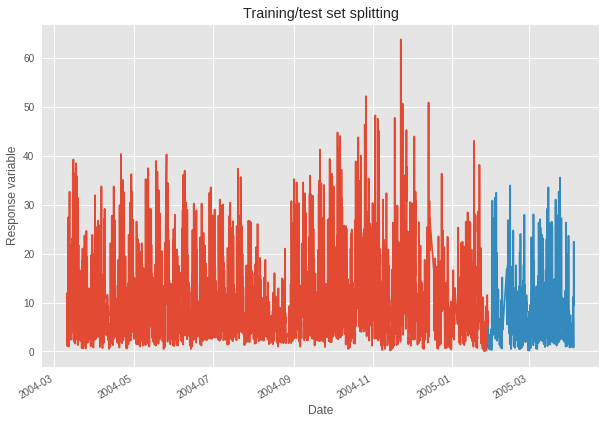

In [ ]:
tss = TimeSeriesSplit(n_splits = 5)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

y = df['C6H6(GT)']
X = df.drop(['C6H6(GT)_transformed', 'C6H6(GT)'], axis=1)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


y_train.plot()
y_test.plot()
plt.ylabel('Response variable')
plt.title('Training/test set splitting')
plt.show()

The training set is older (red) than test set (blue).

### Preprocessor pipeline

As I was planning I will use log transformer for the target and some of the independent variables. After log transformation I'm using `MinMaxScaler`  because of outliers. As the more robust technique I'm using median strategy for imputing the missing values 

In [ ]:
print('Shape before the transformation:')
print(X_train.shape)
print(X_test.shape)
transformer = FunctionTransformer(np.log10)

num_log_pipeline = Pipeline([
    ('transform', transformer),
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='median')),
#    ('poly', PolynomialFeatures(3)),
])

num_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='median')),
])

preprocessor = ColumnTransformer(
    transformers=[
      ('cat', num_log_pipeline, X.columns.difference(['AH', 'RH', 'T'])),
      ('num', num_pipeline, ['AH', 'RH', 'T']),
    
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('PCA', PCA(n_components=0.99)),
#    ('model', LinearRegression())
])


X_train_tr = pipeline.fit_transform(X_train)
X_test_tr = pipeline.transform(X_test)

print('Shape after the transformation:')
print(X_train_tr.shape)
print(X_test_tr.shape)

Shape before the transformation:
(7493, 11)
(1498, 11)
Shape after the transformation:
(7493, 9)
(1498, 9)


We can see here then out of 10 variables 4 is enought to cover 99% of the variance 

### Principal components

Text(0.5, 1.0, 'Scree Plot')

Text(0.5, 0, 'Principal Component')

Text(0, 0.5, 'Variance Explained')

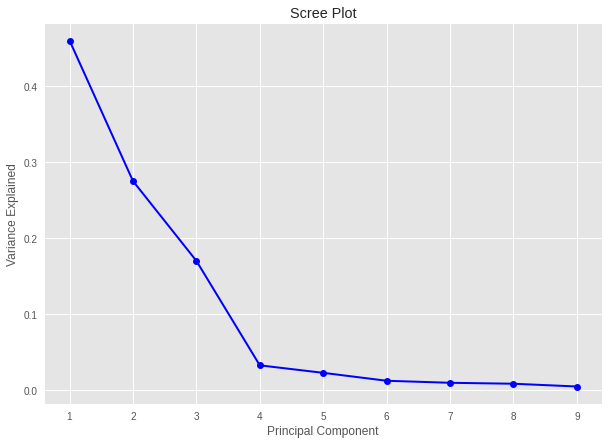

In [ ]:
PCA_values = np.arange(pipeline['PCA'].n_components_) + 1
plt.plot(PCA_values, pipeline['PCA'].explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

We can see here then out of 10 variables 4 is enought to cover 99% of the variance and actually the first two component cover the most variance, which confirm that our features have multicollinearity 

# Modelling

### Model evaluation function

For my model evaluation I've chosen two the most popular metrics:
* RMSE because it's in units of response variable (but after log transformation it's quite hard to interpret)
* r2 is explained variance and easy to interpret compare to RMSE

In [ ]:
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, cv):
  
  results = cross_validate(estimator=pipeline, X=X_train, y=y_train, cv=cv, scoring=['neg_mean_squared_error', 'r2'], return_train_score=True)

  ppl = pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)

  train_score_rmse = np.sqrt(np.abs(results['train_neg_mean_squared_error']))
  val_score_rmse = np.sqrt(np.abs(results['test_neg_mean_squared_error']))

  train_score_r2 = results['train_r2']
  val_score_r2 = results['test_r2']

  print(f'\nTrain Score RMSE: {train_score_rmse.mean():.3f}, Std: {train_score_rmse.std():.3f}')
  print(f'Validation Score RMSE: {val_score_rmse.mean():.3f}, Std: {val_score_rmse.std():.3f}')
  print(f'Test Score: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')

  print(f'\nTrain Score r2: {train_score_r2.mean():.3f}, Std: {train_score_r2.std():.3f}')
  print(f'Validation Score r2: {val_score_r2.mean():.3f}, Std: {val_score_r2.std():.3f}')
  print(f'Test Score r2: {pipeline.score(X_test, y_test):.3f}')

### Baseline model

Let's make a baseline model

In [ ]:
model = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
#   ('PCA', PCA(n_components=0.99)),
    ('model', model)
])

evaluate_model(clone(pipeline), X_train, y_train, X_test, y_test, tss)



Train Score RMSE: 1.132, Std: 0.188
Validation Score RMSE: 2.122, Std: 0.836
Test Score: 0.709

Train Score r2: 0.974, Std: 0.007
Validation Score r2: 0.911, Std: 0.047
Test Score r2: 0.987


We can see some overfitting here. Let's try model with PCA included

### PCA Model

In [ ]:
model = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('PCA', PCA(n_components=0.99)),
    ('model', model)
])

evaluate_model(clone(pipeline), X_train, y_train, X_test, y_test, tss)


Train Score RMSE: 2.188, Std: 0.113
Validation Score RMSE: 2.888, Std: 1.033
Test Score: 2.712

Train Score r2: 0.905, Std: 0.006
Validation Score r2: 0.850, Std: 0.062
Test Score r2: 0.814


Looks better, let's try some feature regularization using Elastic Net 

### ElasticNet model

In [ ]:
model = TransformedTargetRegressor(regressor=ElasticNet(), func=np.log, inverse_func=np.exp)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

grid = {
    'model__regressor__max_iter': [1, 5, 10],
    'model__regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], # np.linspace(0, 300, 10),
    'model__regressor__l1_ratio': np.arange(0, 1.1, 0.1) 
}

gs = GridSearchCV(pipeline, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=tss)


In [ ]:
%%time
tmp = gs.fit(X_train, y_train);

CPU times: user 5.2 s, sys: 262 ms, total: 5.47 s
Wall time: 24.2 s


In [ ]:
pipeline = gs.best_estimator_

evaluate_model(clone(pipeline), X_train, y_train, X_test, y_test, tss)


Train Score RMSE: 0.910, Std: 0.285
Validation Score RMSE: 1.098, Std: 0.437
Test Score: 0.631

Train Score r2: 0.982, Std: 0.011
Validation Score r2: 0.974, Std: 0.024
Test Score r2: 0.990


I think this is a good result. Let's see feature importances

### Feature importances

Let's see graphically first

Text(0.5, 1.0, 'Feature importances')

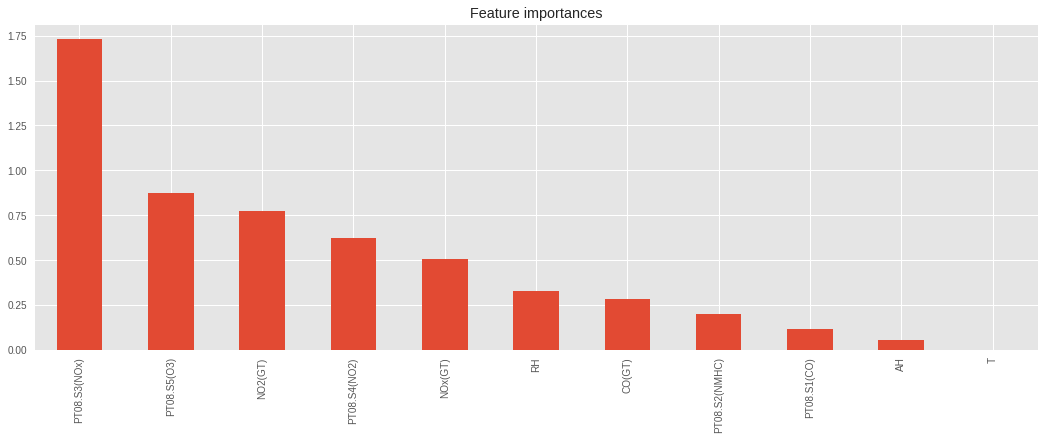

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet(alpha=0.01,
                         l1_ratio=0.30 ,max_iter=10))
])

tmp = pipeline.fit(X_train, np.log(y_train))

feature_importance = pd.Series(index = X_train.columns, data = np.abs(pipeline.named_steps['model'].coef_))

feature_importance.sort_values(ascending=False).plot(kind = 'bar', figsize = (18,6))
plt.title('Feature importances')

We can see graphically that only the first 6 features has importance for the model. Let's look at their p-values

In [ ]:
pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
])

params = np.append(pipeline.named_steps['model'].intercept_, pipeline.named_steps['model'].coef_)
predictions = pipeline.predict(X_train)

newX = np.append(np.ones((len(X_train),1)), pipeline2.transform(X_train), axis=1)
MSE = (sum((np.log(y_train) - predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params / sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,5)
params = np.round(params,4)

myDF3 = pd.DataFrame()
ind = ['Intercept'] + X_train.columns.to_list()
myDF3['Variable'] = ind
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["p valuse"] = [params,sd_b,ts_b,p_values]
myDF3.set_index('Variable', inplace=True)
myDF3.reindex(myDF3.Coefficients.abs().sort_values(ascending=False).index)

,Coefficients,Standard Errors,t values,p valuse
Variable,,,,
PT08.S3(NOx),1.7305,0.064,27.014,0.00000
PT08.S5(O3),0.8713,0.036,24.533,0.00000
NO2(GT),-0.7746,0.045,-17.233,0.00000
PT08.S4(NO2),0.6246,0.042,14.705,0.00000
NOx(GT),0.5080,0.035,14.398,0.00000
RH,-0.3248,0.031,-10.622,0.00000
CO(GT),0.2836,0.027,10.376,0.00000
Intercept,0.2183,0.051,4.276,0.00002
PT08.S2(NMHC),0.1980,0.047,4.197,0.00003


We can see that all coefficients are statistically significant

## Residual analysis

Let's look at the plots

YellowbrickAttributeError: ignored

YellowbrickAttributeError: ignored

0.9263950373751514

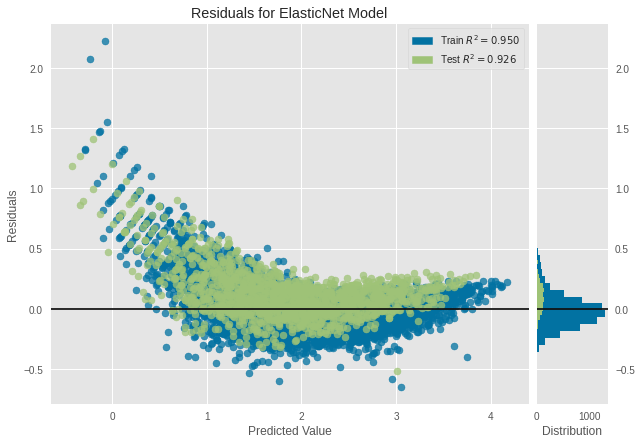

In [ ]:
visualizer = ResidualsPlot(pipeline)

visualizer.fit(X_train, np.log(y_train))  # Fit the training data to the visualizer
visualizer.score(X_test, np.log(y_test))  # Evaluate the model on the test data
visualizer.show(hist=False, qqplot=True)                 

We can see the pattern here which means linear model isn't a good choice here. Unfortunately I don't have time today, so I will leave it as is. Residual distribution is close to normal. Let's see outliers:

CooksDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f167af2f070>)

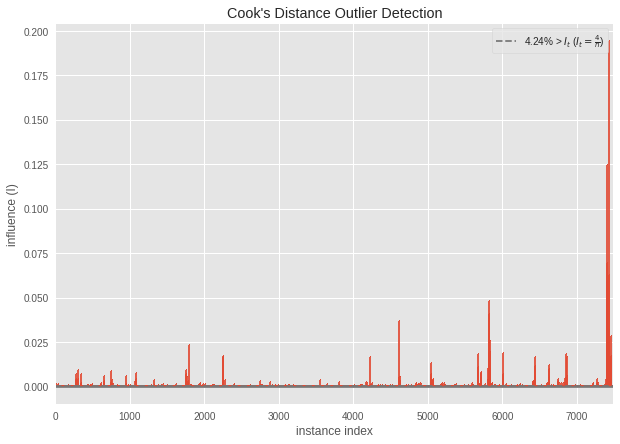

In [ ]:
from yellowbrick.regressor import CooksDistance
X_train2 = pipeline2.transform(X_train)
visualizer = CooksDistance(draw_threshold=True, linefmt="C0-", markerfmt=",")
visualizer.fit(X_train2, np.log(y_train))
visualizer.show()

It looks like there are too much outliers which is one more indication that linear model doesn't fit for this data. Let's try out polynomial features

In [ ]:
num_log_pipeline = Pipeline([
    ('transform', transformer),
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(3)),
])

num_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='median')),
])

preprocessor = ColumnTransformer(
    transformers=[
      ('cat', num_log_pipeline, X.columns.difference(['AH', 'RH', 'T'])),
      ('num', num_pipeline, ['AH', 'RH', 'T']),
    
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet(alpha=0.01,
                         l1_ratio=0.30 ,max_iter=10))
])

tmp = pipeline.fit(X_train, y_train)

evaluate_model(clone(pipeline), X_train, y_train, X_test, y_test, tss)


Train Score RMSE: 0.844, Std: 0.125
Validation Score RMSE: 1.222, Std: 0.225
Test Score: 1.443

Train Score r2: 0.986, Std: 0.003
Validation Score r2: 0.973, Std: 0.006
Test Score r2: 0.947


YellowbrickAttributeError: ignored

YellowbrickAttributeError: ignored

-104.05099504581318

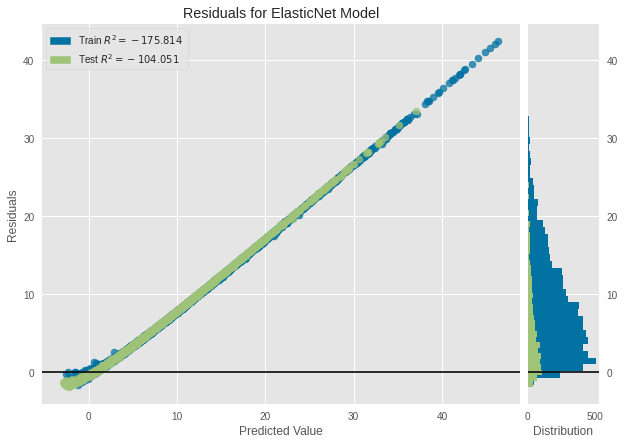

In [ ]:
visualizer = ResidualsPlot(pipeline)

visualizer.fit(X_train, np.log(y_train))  # Fit the training data to the visualizer
visualizer.score(X_test, np.log(y_test))  # Evaluate the model on the test data
visualizer.show(hist=False, qqplot=True)        